In [8]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn.datasets
import sklearn.model_selection
from sklearn.preprocessing import OneHotEncoder

# import mnist digits dataset
mnist = tf.keras.datasets.mnist # Object of the MNIST dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [9]:
# # DATA TRUNCATION FOR TEST
# bite = 300
# x_train = x_train[:bite]
# y_train = y_train[:bite]
# x_test = x_test[:bite]
# y_test = y_test[:bite]

In [10]:
# Normalize the train dataset
x_train = tf.keras.utils.normalize(x_train, axis=1)
# Normalize the test dataset
x_test = tf.keras.utils.normalize(x_test, axis=1)



# Hilbert Curve translation

In [11]:
# Hilbert path generator
# ALL CREDIT TO: https://github.com/jakubcerveny/gilbert/blob/master/gilbert2d.py
# ALL CREDIT TO @jakubcerveny on GitHub

def sgn(x):
    return -1 if x < 0 else (1 if x > 0 else 0)

def generate_path(x,y,ax,ay,bx,by):
    w = abs(ax + ay)
    h = abs(bx + by)

    (dax, day) = (sgn(ax), sgn(ay)) # unit major direction
    (dbx, dby) = (sgn(bx), sgn(by)) # unit orthogonal direction

    if h == 1:
        # trivial row fill
        for i in range(0, w):
            yield(x, y)
            (x, y) = (x + dax, y + day)
        return

    if w == 1:
        # trivial column fill
        for i in range(0, h):
            yield(x, y)
            (x, y) = (x + dbx, y + dby)
        return

    (ax2, ay2) = (ax//2, ay//2)
    (bx2, by2) = (bx//2, by//2)

    w2 = abs(ax2 + ay2)
    h2 = abs(bx2 + by2)

    if 2*w > 3*h:
        if (w2 % 2) and (w > 2):
            # prefer even steps
            (ax2, ay2) = (ax2 + dax, ay2 + day)

        # long case: split in two parts only
        yield from generate_path(x, y, ax2, ay2, bx, by)
        yield from generate_path(x+ax2, y+ay2, ax-ax2, ay-ay2, bx, by)

    else:
        if (h2 % 2) and (h > 2):
            # prefer even steps
            (bx2, by2) = (bx2 + dbx, by2 + dby)

        # standard case: one step up, one long horizontal, one step down
        yield from generate_path(x, y, bx2, by2, ax2, ay2)
        yield from generate_path(x+bx2, y+by2, ax, ay, bx-bx2, by-by2)
        yield from generate_path(x+(ax-dax)+(bx2-dbx), y+(ay-day)+(by2-dby),
                              -bx2, -by2, -(ax-ax2), -(ay-ay2))

def hilbert_path(n):
    yield from generate_path(0,0,n,0,0,n)


In [12]:
def dim_reduction(image):
    # Translate 2D image into 1D vector using Hilbert curve
    # image: 2D numpy array (28x28) or (nxn)
    # return: 1D numpy array
    width = image.shape[0]
    
    # Generate Hilbert curve path
    path = hilbert_path(width)
    # 1D vector widthxwidth
    vector = np.zeros(width*width)
    # Fill vector with image values
    for i, (x, y) in enumerate(path):
        vector[i] = image[x][y]
    return vector


In [13]:
# Reduce 28x28 images to 14x14 images by averaging pixel values in 2x2 blocks
def windowed_reduction(image):
    # image: 2D numpy array (28x28) or (nxn)
    # return: 2D numpy array (14x14)
    width = image.shape[0]
    # 2D array 14x14
    reduced = np.zeros((width//2, width//2))
    # Fill reduced with averages of 2x2 blocks
    for i in range(0, width, 2):
        for j in range(0, width, 2):
            reduced[i//2][j//2] = (image[i][j] + image[i+1][j] + image[i][j+1] + image[i+1][j+1]) / 4
    return reduced

# display first image in dataset
# plt.imshow(x_train[0], cmap=plt.cm.binary)

x_train = np.array([windowed_reduction(image) for image in x_train])
x_test = np.array([windowed_reduction(image) for image in x_test])

# plt.imshow(x_train[0], cmap=plt.cm.binary)

### Translating MNIST

Note: This takes a long time!

In [14]:
# ONLY RUN ONE OF THE TWO BELOW

# run for hilbert
# x_train = np.array([dim_reduction(x) for x in x_train])
# x_test = np.array([dim_reduction(x) for x in x_test])

# run for naive
x_train = x_train.reshape(x_train.shape[0], 196)
x_test = x_test.reshape(x_test.shape[0], 196)


print(x_train.shape)


(60000, 196)


In [15]:

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_train.flatten().reshape(-1,1)
y_test = y_test.flatten().reshape(-1,1)

print(x_train.shape)
print(y_train.shape)

# One-hot encode labels
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()

(60000, 196)
(60000, 1)


# Recurrent Neural Network

Problems w/ time series classification:
- LSTM RNN Just takes windows of data and does recognition based off of that
- Taking a sufficiently long window is literally just taking a snapshot of the image and running it thru RNN instead of CNN
- wtf bro lmao.

In [16]:
model = tf.keras.models.Sequential()
model.add(
    # keras.layers.Bidirectional(
      # keras.layers.SimpleRNN(
      #     units=128,
      #     input_shape=[x_train.shape[1], 1]
      # )
      keras.layers.LSTM(
          units=128,
          input_shape=[x_train.shape[1], 1]
      )
    # )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [17]:
print(x_train.shape, y_train.shape)


history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

(60000, 196) (60000, 10)
Epoch 1/20
1688/1688 [==============================] - 236s 138ms/step - loss: 1.4768 - acc: 0.4599 - val_loss: 1.1314 - val_acc: 0.5907
Epoch 2/20
1688/1688 [==============================] - 236s 140ms/step - loss: 1.2438 - acc: 0.5538 - val_loss: 1.1028 - val_acc: 0.6108
Epoch 3/20
1688/1688 [==============================] - 246s 146ms/step - loss: 1.1317 - acc: 0.6013 - val_loss: 0.8767 - val_acc: 0.6963
Epoch 4/20
1688/1688 [==============================] - 239s 141ms/step - loss: 0.9900 - acc: 0.6575 - val_loss: 0.7709 - val_acc: 0.7173
Epoch 5/20
1688/1688 [==============================] - 237s 141ms/step - loss: 0.7535 - acc: 0.7437 - val_loss: 0.4656 - val_acc: 0.8345
Epoch 6/20
1688/1688 [==============================] - 236s 140ms/step - loss: 0.5864 - acc: 0.8034 - val_loss: 0.3924 - val_acc: 0.8655
Epoch 7/20
1688/1688 [==============================] - 237s 140ms/step - loss: 0.4546 - acc: 0.8618 - val_loss: 0.3080 - val_acc: 0.9067
Epoch 8/2

313/313 [==============================] - 13s 40ms/step - loss: 0.0750 - acc: 0.9784
Test accuracy: 0.9783999919891357
Test loss: 0.07502612471580505


C:\Users\blake\AppData\Local\Temp\ipykernel_9124\3507171728.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')


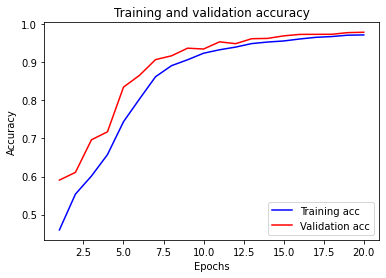

In [21]:
# test on testing set

# print(x_test.shape)
# print(y_test.shape)

test_loss, test_acc = model.evaluate(x_test, y_test)
9
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# plot acc, val_acc
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Naive Training vs Valid.png')


313/313 [==============================] - 14s 45ms/step


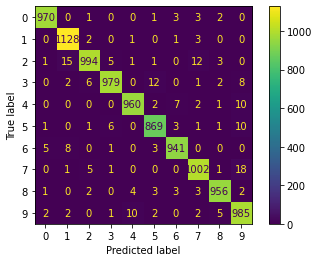

<Figure size 432x288 with 0 Axes>

In [22]:
# creating confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(
    x_test,
    batch_size=None,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

y_pred_prime = np.zeros_like(y_pred)
for i in range(y_pred.shape[0]):  y_pred_prime[i][np.argmax(y_pred[i])] = 1

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_prime.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(0, 10)))
disp.plot()
plt.show()
plt.savefig('Naive CM.png')